# ARK Holding Risk analysis
Taking the snapshot holding of ARK Innovation ETF (ARKK) on 2025-07-18

2025-07-21

In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import plotly.express as px

from utils.data.source import YahooFinanceDB

#### Load ARK Innovation ETF holdings (with GICS meta-data manually added)

In [2]:
h_df = pd.read_csv('data/20250718_ARK_INNOVATION_ETF_ARKK_HOLDINGS.csv', index_col=3, parse_dates=True)
h_df = h_df.dropna(subset=['weight (%)'])

In [172]:
h_df.sort_index()

,date,fund,company,cusip,shares,market value ($),weight (%),GICS Sector,GICS Industry Group,GICS Industry,GICS Sub-Industry,weight
ticker,,,,,,,,,,,,
ABNB,7/18/2025,ARKK,AIRBNB INC-CLASS A,009066101,"474,500","$66,097,850.00",0.89%,Consumer Discretionary,Consumer Services,Hotels Restaurants & Leisure,Hotels Resorts & Cruise Lines,0.009074
ACHR,7/18/2025,ARKK,ARCHER AVIATION INC-A,03945R102,"17,562,964","$235,343,717.60",3.18%,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,0.032423
AMD,7/18/2025,ARKK,ADVANCED MICRO DEVICES,007903107,"1,476,972","$236,921,078.52",3.21%,Information Technology,Semiconductors & Semiconductor Equipment,Semiconductors & Semiconductor Equipment,Semiconductors,0.032728
AMZN,7/18/2025,ARKK,AMAZON.COM INC,023135106,"563,724","$126,206,529.12",1.71%,Consumer Discretionary,Consumer Discretionary Distribution & Retail,Broadline Retail,Broadline Retail,0.017435
BEAM,7/18/2025,ARKK,BEAM THERAPEUTICS INC,07373V105,"6,695,191","$136,916,655.95",1.85%,Health Care,Pharmaceuticals Biotechnology & Life Sciences,Biotechnology,Biotechnology,0.018862
BWXT,7/18/2025,ARKK,BWX TECHNOLOGIES INC,05605H100,"435,959","$62,054,404.06",0.84%,Industrials,Capital Goods,Aerospace & Defense,Aerospace & Defense,0.008564
CERS,7/18/2025,ARKK,CERUS CORP,157085101,"10,549,421","$14,452,706.77",0.20%,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Supplies,0.002039
COIN,7/18/2025,ARKK,COINBASE GLOBAL INC -CLASS A,19260Q107,"1,596,082","$655,590,681.50",8.87%,Financials,Financial Services,Capital Markets,Financial Exchanges & Data,0.090436
CRCL,7/18/2025,ARKK,CIRCLE INTERNET GROUP INC,172573107,"1,719,822","$404,295,755.76",5.47%,Information Technology,Software & Services,IT Services,Internet Services & Infrastructure,0.055771


In [133]:
count_sector = len(h_df['GICS Sector'].unique())
sector_colour = {g: sns.color_palette("tab10", count_sector)[idx] 
                 for idx, g in  enumerate(h_df['GICS Sector'].unique())}

count_indu_group = len(h_df['GICS Industry Group'].unique())
indu_group_colour = {g: sns.color_palette("tab10", count_indu_group)[idx] 
                     for idx, g in  enumerate(h_df['GICS Industry Group'].unique())}

count_indu = len(h_df['GICS Industry'].unique())
indu_colour = {g: sns.color_palette("tab10", count_indu)[idx] for idx, g in  enumerate(h_df['GICS Industry'].unique())}

group_colour_map = {'GICS Sector': sector_colour,
                    'GICS Industry Group': indu_group_colour,
                    'GICS Industry': indu_colour}

def ticker_to_colour(ticker, group_by='GICS Sector'):
    """
    Returns the colour for a given ticker based on the group_by parameter.
    If group_by is None, returns black.
    :param ticker: str -  Ticker symbol of the stock
    :param group_by: str - Grouping criteria, e.g., 'GICS Sector', 'GICS Industry Group', 'GICS Industry'
    """
    if group_by is None:
        print('returning black since group_by == None')
        return (1, 1, 1)
    group = h_df.loc[ticker][group_by]
    if group_by == 'GICS Sector':
        return sector_colour[group]
    elif group_by == 'GICS Industry Group':
        return indu_group_colour[group]
    elif group_by == 'GICS Industry':
        print('warning - colours start to repeat after 10th')
        return indu_colour[group]
    else:
        raise ValueError(f'{group_by} not recognised - only supporting "GICS Sector", "GICS Industry Group" and "GICS Industry"')

In [5]:
START = pd.Timestamp('2020-01-01')
END = pd.Timestamp('2025-07-20')

#### Load asset prices from the internally onboarded Arctic DB data

In [6]:
yf_db = YahooFinanceDB()
# NASDAQ Composite Index
bmk_p_ts = yf_db.load_timeseries(ids='^IXIC',
                                fld='Close',
                                start=START,
                                end=END)
# ARKK ETF held names
prices_ts = yf_db.load_timeseries(ids=tuple(h_df.index),
                                  fld='Close',
                                  start=START,
                                  end=END)
prices_ts = prices_ts.ffill()
ret_ts = prices_ts.pct_change()
bmk_ret_ts = bmk_p_ts.pct_change()

#### Some names don't have good price history

In [7]:
pd.Series({col: prices_ts[col].first_valid_index() for col in prices_ts}).sort_values(ascending=False)

CRCL   2025-06-04
TEM    2024-06-14
GTLB   2021-10-14
HOOD   2021-07-29
RXRX   2021-04-16
COIN   2021-04-14
RBLX   2021-03-10
SOFI   2021-01-04
ACHR   2020-12-18
ABNB   2020-12-10
PLTR   2020-09-30
BEAM   2020-02-06
PINS   2020-01-02
TSLA   2020-01-02
TSM    2020-01-02
TTD    2020-01-02
TWST   2020-01-02
SHOP   2020-01-02
ROKU   2020-01-02
TXG    2020-01-02
VCYT   2020-01-02
TER    2020-01-02
NTRA   2020-01-02
PD     2020-01-02
PACB   2020-01-02
NVDA   2020-01-02
NTLA   2020-01-02
META   2020-01-02
KTOS   2020-01-02
IRDM   2020-01-02
ILMN   2020-01-02
GH     2020-01-02
DE     2020-01-02
CRSP   2020-01-02
CERS   2020-01-02
BWXT   2020-01-02
AMZN   2020-01-02
AMD    2020-01-02
XYZ    2020-01-02
dtype: datetime64[ns]

In [8]:
# only keep names for which we have prices
h_df = h_df.loc[h_df.index.isin(prices_ts.columns)]
h_df['weight'] = h_df['weight (%)'].str.rstrip('%').astype(float) / 100.0
h_df['weight'] = h_df['weight'] / h_df['weight'].sum()

In [9]:
rel_ts = ret_ts.sub(bmk_ret_ts.iloc[:,0], axis=0)

In [10]:
ret_ts.shape

(1393, 39)

In [90]:
window = 3* 252
# relative (vs NDX) daily return time series
rel_ts = ret_ts.sub(bmk_ret_ts.iloc[:,0], axis=0)
rel_ts_subset = rel_ts.iloc[-window:].dropna(axis=1, how='any')
corr_start, corr_end = rel_ts_subset.index[0].strftime('%Y-%m-%d'), rel_ts_subset.index[-1].strftime('%Y-%m-%d')

In [91]:
def correlation_to_distance(corr_matrix):
    return np.sqrt(2 * (1 - corr_matrix))

In [92]:
rho_mat = rel_ts_subset.corr()
dist_mat = correlation_to_distance(rho_mat)

<AxesSubplot:xlabel='TICKER', ylabel='TICKER'>

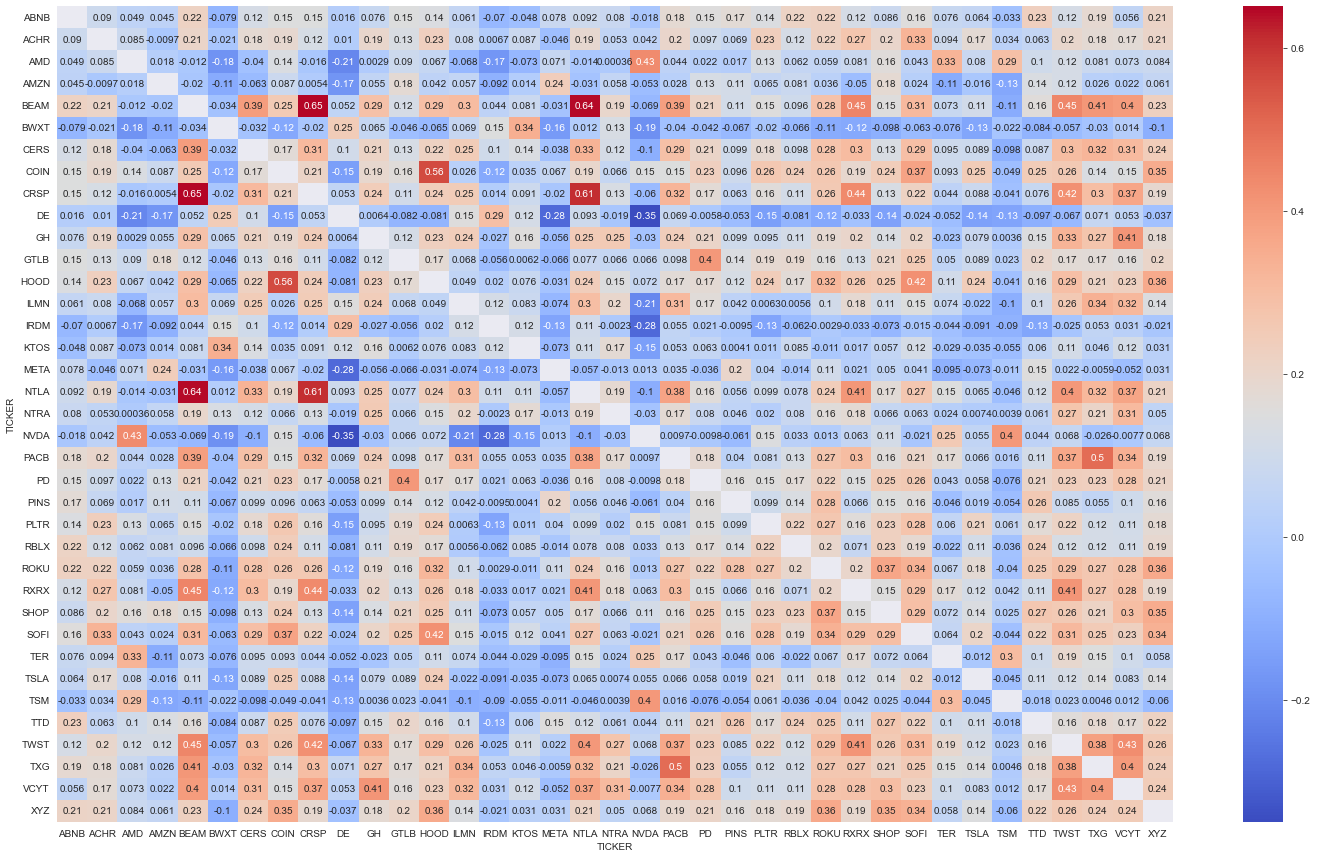

In [93]:
plt.figure(figsize=(25, 15))
sns.heatmap(rho_mat.replace(1, np.nan), annot=True, cmap='coolwarm')

### Performing hierarchical clustering on the distance matrix

C:\Users\kench\AppData\Local\Temp/ipykernel_26796/649526662.py:7: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



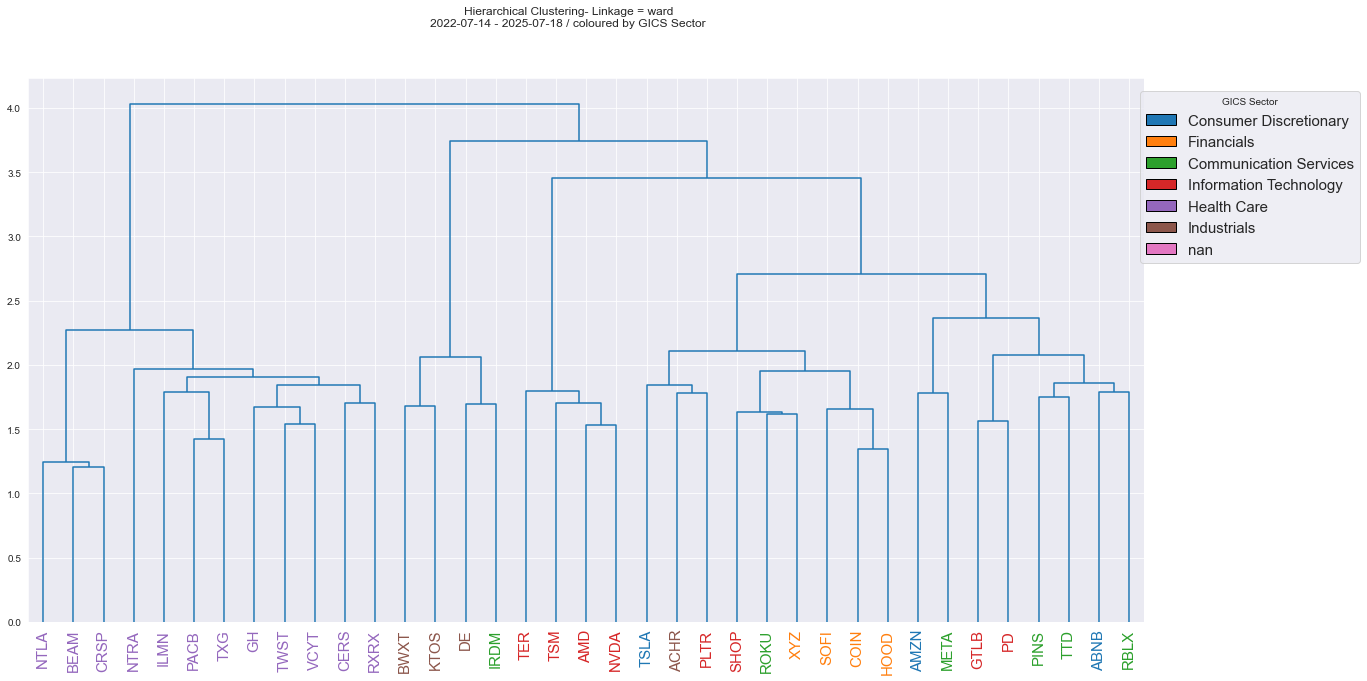

In [99]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(20, 10))
link_method = 'ward'
colour_by = 'GICS Sector'
#colour_by= 'GICS Industry Group'

linkage_data = linkage(dist_mat.values, method=link_method)
dendro = dendrogram(linkage_data, labels=dist_mat.index, leaf_rotation=90, leaf_font_size=15, color_threshold=0)

x_labels = plt.gca().get_xmajorticklabels()
for lbl in x_labels:
    lbl.set_color(ticker_to_colour(lbl.get_text(), group_by=colour_by))
    
plt.suptitle(f'Hierarchical Clustering- Linkage = {link_method}\n'
             f'{corr_start} - {corr_end} / coloured by {colour_by}')

# adding GICS colour coding as legends
custom_legend = [Patch(facecolor=_c, edgecolor='black', label=_g) for _g, _c in group_colour_map[colour_by].items()]
plt.legend(handles=custom_legend, title=colour_by, loc='upper right',  bbox_to_anchor=(1.2, 0.99), fontsize=15)
plt.show()

### We plot the correlation matrix again but using the order of the nodes in the dendrogram

<AxesSubplot:xlabel='TICKER', ylabel='TICKER'>

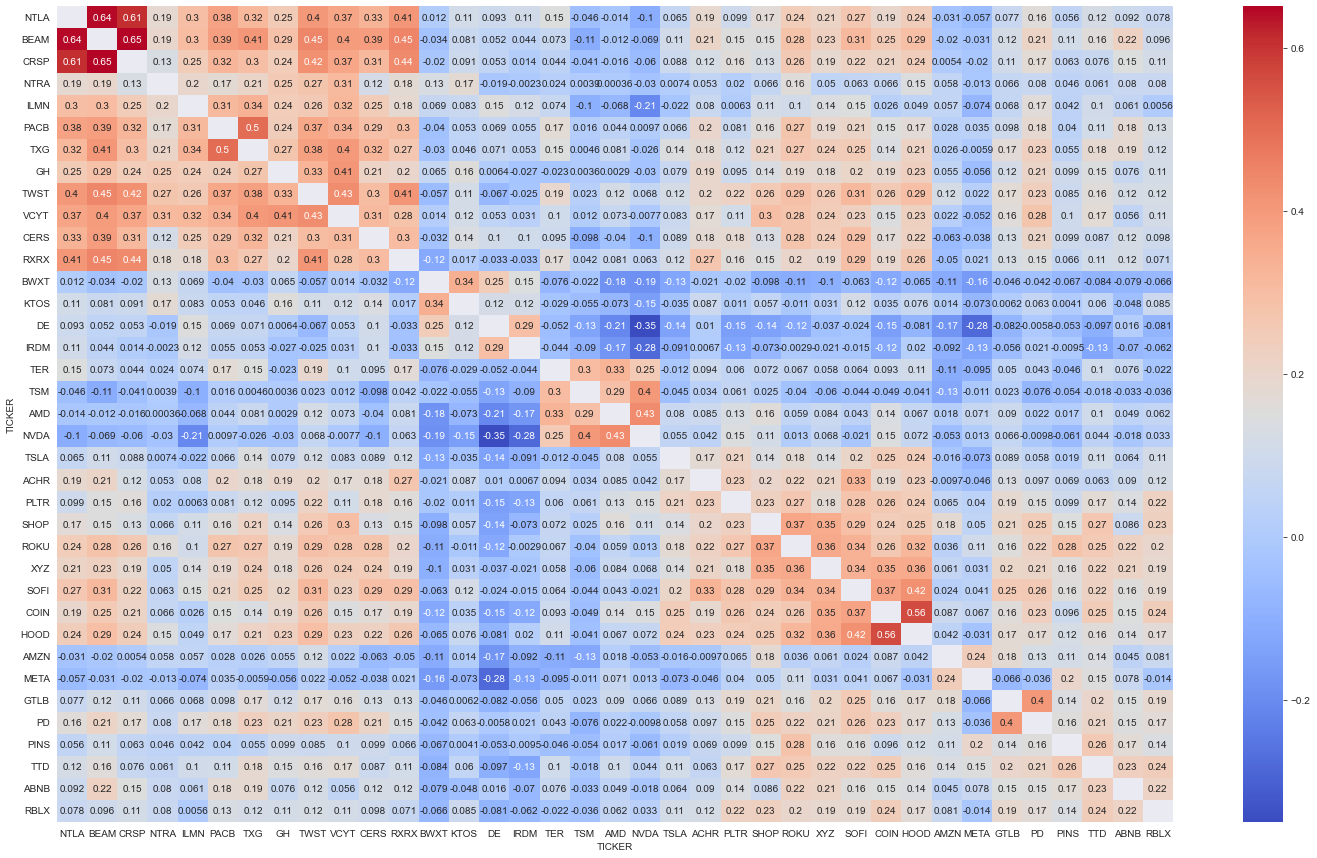

In [104]:
plt.figure(figsize=(25, 15))
node_order = dendro['ivl']
rho_mat_ordered = rho_mat.loc[node_order, node_order]

sns.heatmap(rho_mat_ordered.replace(1, np.nan), annot=True, cmap='coolwarm')

### Using tSNE to project the distance matrix into 2D space

In [96]:
from sklearn.manifold import TSNE
TSNE_PERP = 10
# Using TSNE to project a set of points based on a precomputed distance matrix
tsne_projection = TSNE(n_components=2, perplexity=TSNE_PERP, metric="precomputed", random_state=1).fit_transform(dist_mat.values)

C:\ProgramData\anaconda3\envs\dev\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



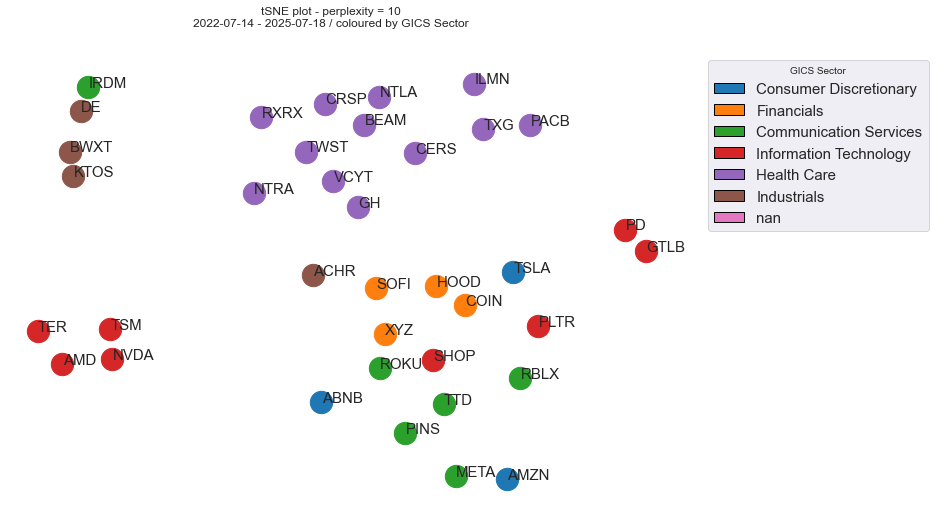

In [97]:
ax_tsne = plt.figure(figsize=(12, 8))
colour_by = 'GICS Sector'
#colour_by= 'GICS Industry Group'

for i, ticker in enumerate(dist_mat.columns):
    x, y = tsne_projection[i][0], tsne_projection[i][1]
    plt.scatter(x, y, 
                color=ticker_to_colour(ticker, group_by=colour_by),
                s=500)
    plt.text(x + 0.3,  y + 0.3, ticker, fontsize=15)
    plt.axis("off")
plt.suptitle(f'tSNE plot - perplexity = {TSNE_PERP}\n'
             f'{corr_start} - {corr_end} / coloured by {colour_by}')

# adding GICS colour coding as legends
custom_legend = [Patch(facecolor=_c, edgecolor='black', label=_g) for _g, _c in group_colour_map[colour_by].items()]
ax_tsne.legend(handles=custom_legend, title=colour_by, loc='upper right',  bbox_to_anchor=(1.2, 0.9), fontsize=15)
plt.show()

### Using tSNE to project the distance matrix onto a 3D space

In [98]:
colour_by = 'GICS Industry Group'
TSNE_PERP = 10
tsne_projection_three = pd.DataFrame(TSNE(n_components=3, perplexity=TSNE_PERP, metric="precomputed", random_state=1).fit_transform(dist_mat.values), 
                                     columns=['x', 'y', 'z'], index=dist_mat.columns)

tsne_projection_three['colour'] = pd.Series([ticker_to_colour(ticker, group_by=colour_by) for ticker in dist_mat.columns]).values
fig = px.scatter_3d(
    tsne_projection_three, x='x', y='y', z='z',
    color=tsne_projection_three.colour, 
    text=tsne_projection_three.index,
    title = (f'tSNE plot - perplexity = {TSNE_PERP}\n{corr_start} - {corr_end} / coloured by {colour_by}'),
    height=800,
    width=2000,
)
fig.update_traces(marker_size=8)

C:\ProgramData\anaconda3\envs\dev\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



### Using a minimum spanning tree to visualize the relationships

In [110]:
import networkx as nx
from scipy.sparse.csgraph import minimum_spanning_tree

In [111]:
# Compute the Minimum Spanning Tree
mst = minimum_spanning_tree(dist_mat.values)

# Convert the MST to a dense format and create a graph
mst_dense = mst.toarray()
mst_graph = nx.Graph()

In [112]:
# Add edges to the graph
for i, row in enumerate(mst_dense):
    for j, weight in enumerate(row):
        if weight > 0:  # Only add edges with non-zero weights
            mst_graph.add_edge(dist_mat.index[i], dist_mat.index[j], weight=weight)


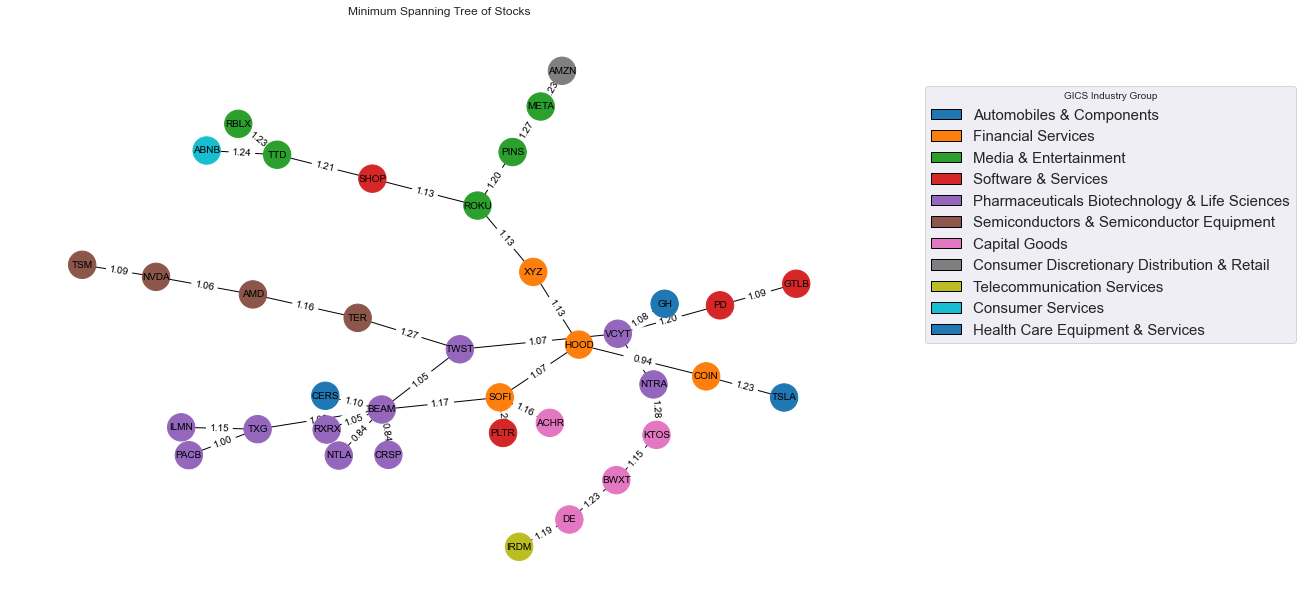

In [136]:
colour_by = 'GICS Industry Group'
#colour_by = 'GICS Sector'

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(mst_graph, seed=42)  # Layout for visualization
nx.draw(mst_graph, pos, with_labels=True, node_size=750, font_size=10, 
        node_color=[ticker_to_colour(ticker, group_by=colour_by) for ticker in mst_graph.nodes()])
labels = nx.get_edge_attributes(mst_graph, 'weight')
nx.draw_networkx_edge_labels(mst_graph, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})

custom_legend = [Patch(facecolor=_c, edgecolor='black', label=_g) for _g, _c in group_colour_map[colour_by].items()]
plt.legend(handles=custom_legend, title=colour_by, loc='upper right',  bbox_to_anchor=(1.5, 0.9), fontsize=15)

plt.title("Minimum Spanning Tree of Stocks")
plt.show()

### Using a partial correlation network graph to visualize the relationships
a partial correlation matrix measures the correlation of each pair of nodes while controlling for the effects of all other nodes in the network

In [139]:
corr_mat_val = rho_mat.values
# need to invert the correlation matrix
corr_mat_inv = np.linalg.inv(corr_mat_val)

In [143]:
partial_corr = -corr_mat_inv / np.sqrt(np.outer(np.diag(corr_mat_inv), np.diag(corr_mat_inv)))
np.fill_diagonal(partial_corr, 0)

In [175]:
pd.DataFrame(partial_corr, index=rho_mat.index, columns=rho_mat.columns).loc[['NVDA', 'AMD', 'TSM', 'ILMN', 'IRDM'], 
                                                                             ['NVDA', 'AMD', 'TSM', 'ILMN', 'IRDM']]

TICKER,NVDA,AMD,TSM,ILMN,IRDM
TICKER,,,,,
NVDA,0.000000,0.261310,0.268397,-0.139344,-0.148850
AMD,0.261310,0.000000,0.092875,-0.010666,-0.024474
TSM,0.268397,0.092875,0.000000,-0.037490,0.027502
ILMN,-0.139344,-0.010666,-0.037490,0.000000,0.036443
IRDM,-0.148850,-0.024474,0.027502,0.036443,0.000000


Text(0.5, 0.98, 'Partial Correlation Network Graph')

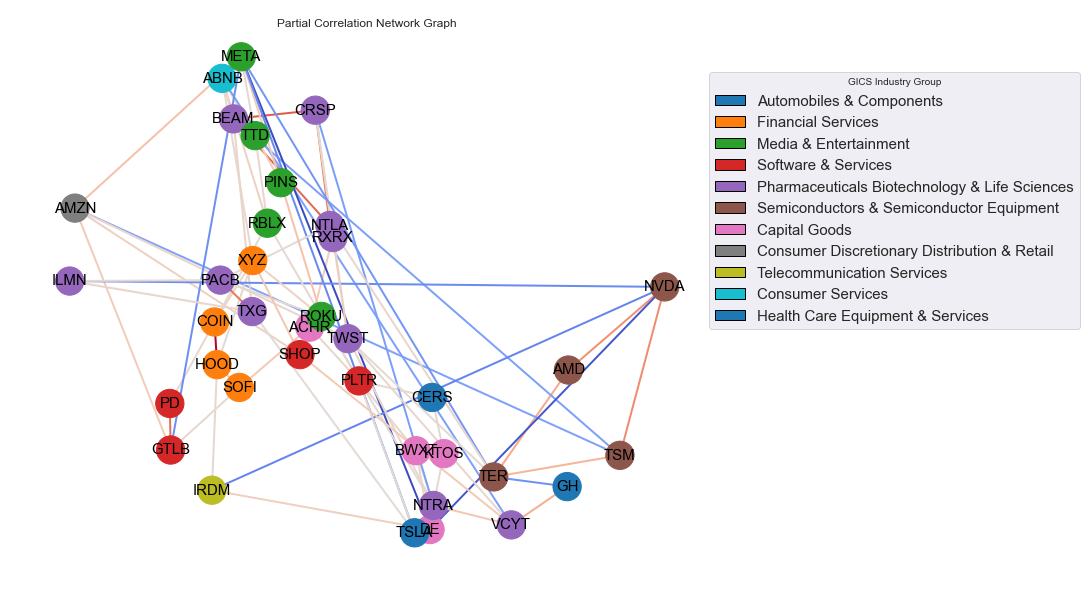

In [173]:
threshold = 0.1  # you can adjust this, only show the more important relationships
G = nx.Graph()
tickers = rho_mat.index
for i in range(len(tickers)):
    G.add_node(tickers[i])
    
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        if abs(partial_corr[i, j]) > threshold:
            G.add_edge(tickers[i], tickers[j], weight=partial_corr[i, j])
            
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # force-directed layout

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

nx.draw(G, pos, with_labels=True, 
        node_color=[ticker_to_colour(ticker, group_by=colour_by) for ticker in rho_mat.index],
        edge_color=weights, edge_cmap=plt.cm.coolwarm, width=2,
        node_size=800, font_size=15)

custom_legend = [Patch(facecolor=_c, edgecolor='black', label=_g) for _g, _c in group_colour_map[colour_by].items()]
plt.legend(handles=custom_legend, title=colour_by, loc='upper right',  bbox_to_anchor=(1.5, 0.9), fontsize=15)
plt.suptitle('Partial Correlation Network Graph')